In [ ]:
## importation Libs

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread


import sys

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

from torch.optim import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import sklearn.metrics as skm

import time

import copy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
## initialize Constante Model
numbers_epochs = 1500
learning_rate = 5 * (10 ** -5)


In [ ]:
## Call and Download The Model

def initialize_model():

  ModelVGG19 = torchvision.models.vgg19(pretrained = True)

  """ Freeze All the Layers  """

  for p in ModelVGG19.parameters():
    p.requires_grad = False

  ModelVGG19.eval()
  ModelVGG19.to(device)

  return ModelVGG19

In [ ]:
ModelVGG19 = initialize_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 97.9MB/s]


In [ ]:
def create_image_data_styles_transfer():
  image_content = imread('https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg/1920px-De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
  image_style = imread('https://upload.wikimedia.org/wikipedia/commons/8/86/Edvard_Munch_-_The_Scream_-_Google_Art_Project.jpg')

  print("from image_content shape", image_content.shape)
  print("from image_style shape", image_style.shape)

  image_target = np.random.randint(low = 0 , high = 255, size = image_content.shape, dtype= np.uint8)
  print("from image_target shape" , image_target.shape)

  return image_content, image_style, image_target

In [ ]:
image_content, image_style, image_target =  create_image_data_styles_transfer()

<ipython-input-6-eca66d1d9aef>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_content = imread('https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg/1920px-De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
<ipython-input-6-eca66d1d9aef>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_style = imread('https://upload.wikimedia.org/wikipedia/commons/8/86/Edvard_Munch_-_The_Scream_-_Google_Art_Project.jpg')


from image_content shape (1072, 1920, 3)
from image_style shape (7880, 6232, 3)
from image_target shape (1072, 1920, 3)


In [ ]:
def apply_images_transformation(image_content, image_style, image_target):

  ## Create The Transformation

  """ unsqueeze(0).to(device) --> to Covert For a Tensor 4D and push on GPU  """

  Transform_setting = T.Compose([T.ToTensor(), T.Resize(256), T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
  image_content_T = Transform_setting(image_content).unsqueeze(0).to(device)
  image_style_T = Transform_setting(image_style).unsqueeze(0).to(device)
  image_target_T = Transform_setting(image_target).unsqueeze(0).to(device)

  ## Check The size

  print("from image_content_T shape", image_content_T.shape)
  print("from image_style_T shape", image_style_T.shape)
  print("from image_target_T shape" , image_target_T.shape)

  return image_content_T, image_style_T, image_target_T



In [ ]:
image_content_T, image_style_T, image_target_T = apply_images_transformation(image_content, image_style, image_target)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


from image_content_T shape torch.Size([1, 3, 256, 458])
from image_style_T shape torch.Size([1, 3, 323, 256])
from image_target_T shape torch.Size([1, 3, 256, 458])


In [ ]:
def plot_image_befor_transfer_styles(image_content_T, image_style_T, image_target_T):

  ## plot The images

  fig, ax = plt.subplots(1,3, figsize=(18, 6))

  pic_content = image_content_T.cpu().squeeze().numpy().transpose((1, 2, 0))
  pic_content = (pic_content - np.min(pic_content)) / (np.max(pic_content)- np.min(pic_content))

  ax[0].imshow(pic_content)
  ax[0].set_title("Content Image")

  pic_target = image_target_T.cpu().squeeze().numpy().transpose((1, 2, 0))
  pic_target = (pic_target - np.min(pic_target)) / (np.max(pic_target)- np.min(pic_target))

  ax[1].imshow(pic_target)
  ax[1].set_title("Target Image")

  pic_style = image_style_T.cpu().squeeze().numpy().transpose((1, 2, 0))
  pic_style = (pic_style - np.min(pic_style)) / (np.max(pic_style)- np.min(pic_style))

  ax[2].imshow(pic_style)
  ax[2].set_title("Style Image")

  plt.show()


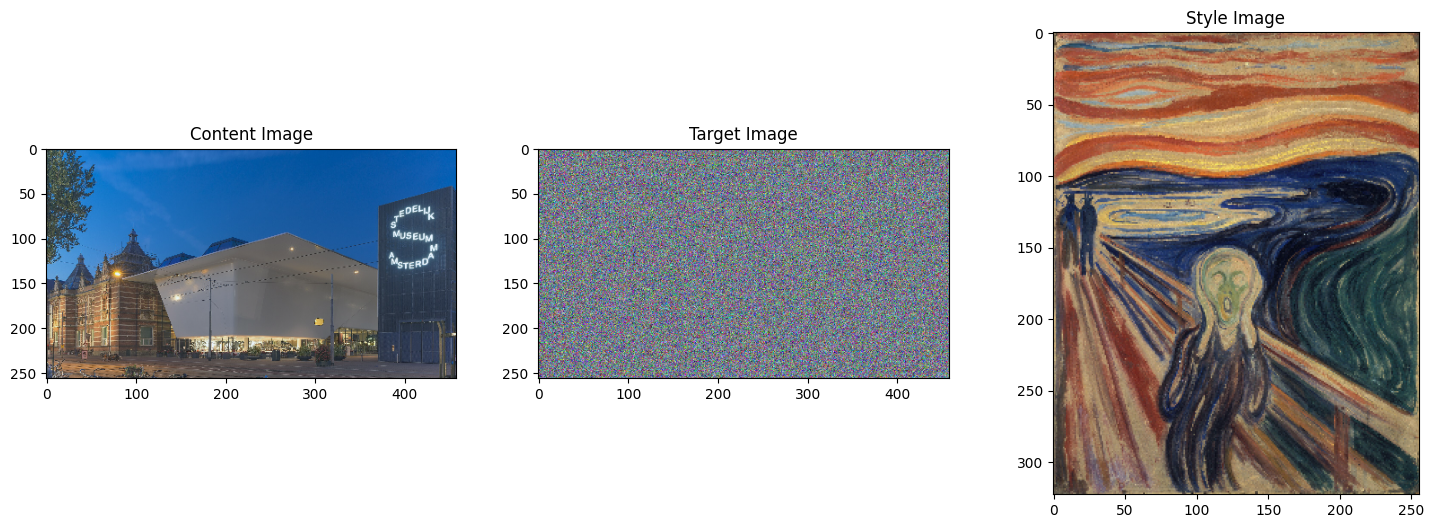

In [ ]:
plot_image_befor_transfer_styles(image_content_T, image_style_T, image_target_T)

In [ ]:
def get_feature_maps(ModelVGG19, image_parametre):

  ## initialize the feature maps lists

  img = image_parametre
  feature_maps = []
  feature_names = []

  Conv2dLayerIndex = 0

  for layer_index in range(len(ModelVGG19.features)):

    img = ModelVGG19.features[layer_index](img)

    if "Conv2d" in str(ModelVGG19.features[layer_index]):
      feature_maps.append(img)
      feature_names.append('ConvLayer_' + str(Conv2dLayerIndex))
      Conv2dLayerIndex += 1

  return feature_maps, feature_names

In [ ]:
## Call & preparer all the params

feature_maps_content, feature_names_content = get_feature_maps(ModelVGG19, image_content_T)
feature_maps_style, feature_names_style = get_feature_maps(ModelVGG19, image_style_T)


In [ ]:
def gramm_matrix(matrix):

## Tack the Size From the Matrix

  _, chanel, height, width = matrix.shape
  matrix = matrix.view(chanel, height * width)

  # print("from Matrix shape ", matrix.shape)

  """ Compute the Gramm Matrix """

  G_matrix = torch.mm(matrix, matrix.t()) / (chanel * height * width)

  return G_matrix

In [ ]:
def print_info_features(feature_maps, feature_names):

  for i in range(len(feature_names)):
    print('Features map "%s" is size %s' % (feature_names[i], (feature_maps[i].shape)))


In [ ]:
print_info_features(feature_maps_content, feature_names_content)

Features map "ConvLayer_0" is size torch.Size([1, 64, 256, 458])
Features map "ConvLayer_1" is size torch.Size([1, 64, 256, 458])
Features map "ConvLayer_2" is size torch.Size([1, 128, 128, 229])
Features map "ConvLayer_3" is size torch.Size([1, 128, 128, 229])
Features map "ConvLayer_4" is size torch.Size([1, 256, 64, 114])
Features map "ConvLayer_5" is size torch.Size([1, 256, 64, 114])
Features map "ConvLayer_6" is size torch.Size([1, 256, 64, 114])
Features map "ConvLayer_7" is size torch.Size([1, 256, 64, 114])
Features map "ConvLayer_8" is size torch.Size([1, 512, 32, 57])
Features map "ConvLayer_9" is size torch.Size([1, 512, 32, 57])
Features map "ConvLayer_10" is size torch.Size([1, 512, 32, 57])
Features map "ConvLayer_11" is size torch.Size([1, 512, 32, 57])
Features map "ConvLayer_12" is size torch.Size([1, 512, 16, 28])
Features map "ConvLayer_13" is size torch.Size([1, 512, 16, 28])
Features map "ConvLayer_14" is size torch.Size([1, 512, 16, 28])
Features map "ConvLayer_1

In [ ]:
def plot_image_features(feature_maps, feature_names):

  fig, ax = plt.subplots(2,5, figsize=(18, 6))

  for i in range(5):

    pic_features = np.mean(feature_maps[i].cpu().squeeze().numpy(), axis = 0)
    pic_features = (pic_features - np.min(pic_features)) / (np.max(pic_features)- np.min(pic_features))

    ax[0, i].imshow(pic_features , cmap= 'gray')
    ax[0, i].set_title("Content Layer " + str(feature_names[i]))

    pic_gramm_freatures = gramm_matrix(feature_maps[i]).cpu().numpy()
    pic_gramm_freatures = (pic_gramm_freatures - np.min(pic_gramm_freatures)) / (np.max(pic_gramm_freatures)- np.min(pic_gramm_freatures))

    ax[1, i].imshow(pic_gramm_freatures , cmap= 'gray', vmax = 0.1)
    ax[1, i].set_title("Gramm Matrix , Layer" + str(feature_names[i]))

  plt.tight_layout()
  plt.show()

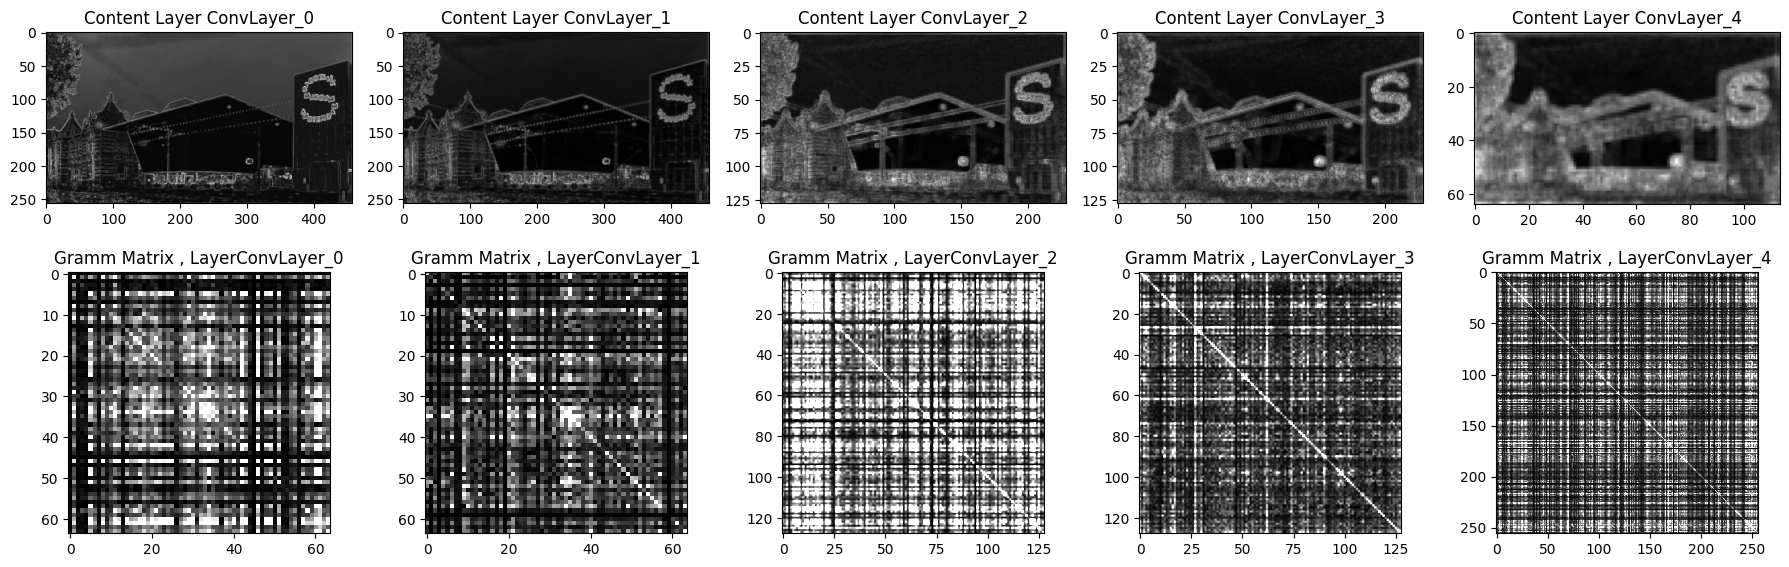

In [ ]:
plot_image_features(feature_maps_content, feature_names_content)

In [ ]:
def plot_image_features_style(feature_maps, feature_names):

  fig, ax = plt.subplots(2,5, figsize=(18, 6))

  for i in range(5):

    pic_features = np.mean(feature_maps[i].cpu().squeeze().numpy(), axis = 0)
    pic_features = (pic_features - np.min(pic_features)) / (np.max(pic_features)- np.min(pic_features))

    ax[0, i].imshow(pic_features , cmap= 'hot')
    ax[0, i].set_title("Content Layer " + str(feature_names[i]))

    pic_gramm_freatures = gramm_matrix(feature_maps[i]).cpu().numpy()
    pic_gramm_freatures = (pic_gramm_freatures - np.min(pic_gramm_freatures)) / (np.max(pic_gramm_freatures)- np.min(pic_gramm_freatures))

    ax[1, i].imshow(pic_gramm_freatures , cmap= 'hot', vmax = 0.1)
    ax[1, i].set_title("Gramm Matrix , Layer" + str(feature_names[i]))

  plt.tight_layout()
  plt.show()

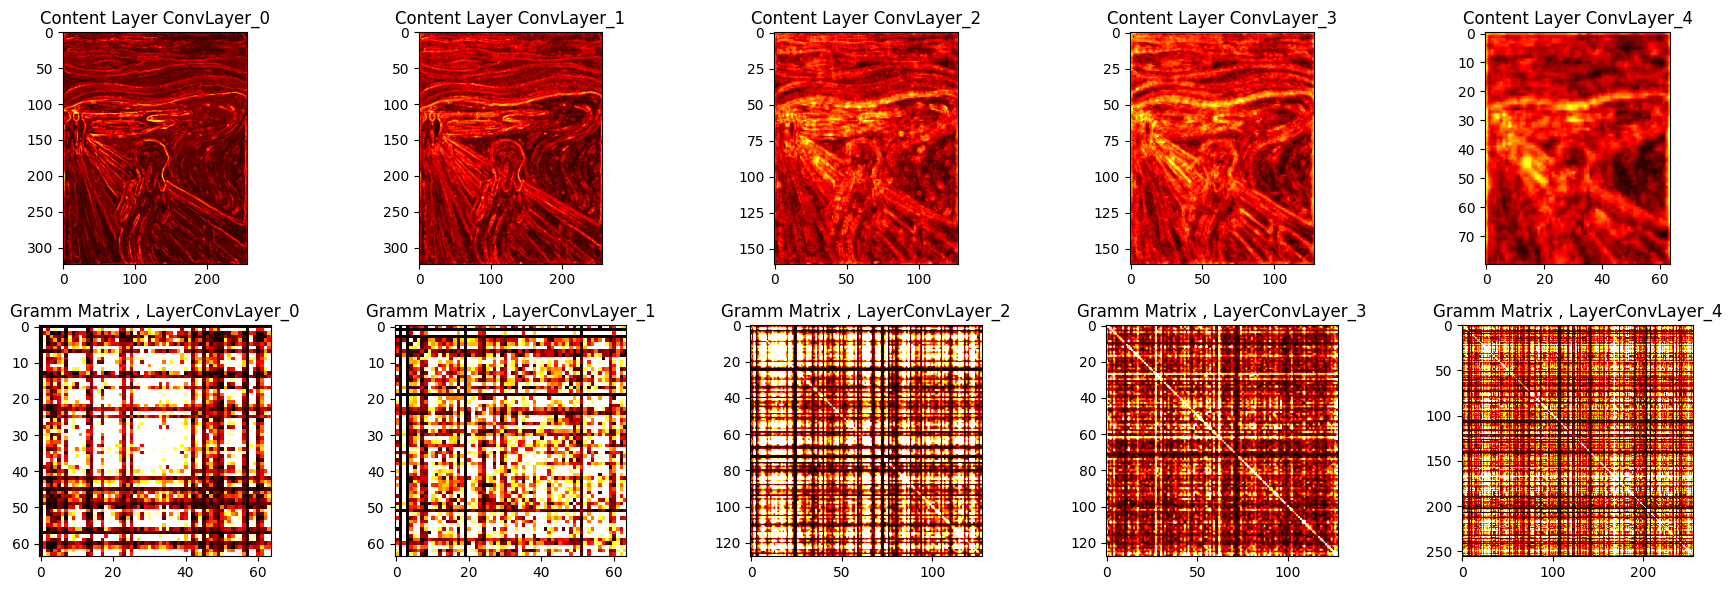

In [ ]:
plot_image_features_style(feature_maps_style, feature_names_style)

# ***Now The Transfer Style***

In [ ]:
def define_layers_to_transfer_style():
  layers_from_content = ['ConvLayer_1', 'ConvLayer_4']
  layers_from_style = ['ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4', 'ConvLayer_5']
  wights_from_style = [1 ,0.5, 0.5, 0.2, 0.1]

  ## Copy and Transfer

  return layers_from_content, layers_from_style, wights_from_style


In [ ]:
layers_from_content, layers_from_style, wights_from_style = define_layers_to_transfer_style()

In [ ]:
def train_model(image_parms, layers_from_content, layers_from_style, wights_from_style, feature_maps_content , feature_maps_style, numbers_epochs, learning_rate):

  """Clone and push on GPU, Change the grade We gonna Train"""

  image_traget = image_parms.clone()
  image_traget.requires_grad = True
  image_traget = image_traget.to(device)
  scaler_style = 1e6 ## Try diferent Sclaing


  optimizer = torch.optim.RMSprop([image_traget], lr=learning_rate)

  for epochi in range(numbers_epochs):

    feature_maps_traget, feature_names_traget = get_feature_maps(ModelVGG19, image_parms)

    loss_content = 0
    loss_style = 0


    for layeries in range(len(feature_names_traget)):

        if feature_names_traget[layeries] in layers_from_content:

          loss_content += torch.mean((feature_maps_traget[layeries] - feature_maps_content[layeries]) ** 2 )

        if feature_names_traget[layeries] in layers_from_style:

          Gramm_target = gramm_matrix(feature_maps_traget[layeries])
          Gramm_style = gramm_matrix(feature_maps_style[layeries])

          loss_style += torch.mean((Gramm_target - Gramm_style) ** 2 ) * wights_from_style[layers_from_style.index(feature_names_traget[layeries])]


  # print("From Loss content ", loss_content, "and from loss Style ", loss_style)
    loss_combine = (scaler_style * loss_style) + loss_content
    # print("From Loss loss_combine ", loss_combine)
    # print("Im Still learn the Epochi number is: ", epochi+1 ," From ", numbers_epochs)

    optimizer.zero_grad()
    loss_combine.backward()
    optimizer.step()

# print("Im Still learn the Epochi number is: ", epochi+1 ," From ", numbers_epochs)



In [ ]:
train_model(image_target_T, layers_from_content, layers_from_style, wights_from_style, feature_maps_content , feature_maps_style, numbers_epochs, learning_rate)


RuntimeError: ignored